# Recommendation system
### Using Doc2Vec to build a poetry recommender
- **The first step is to import necessary libraries.**

In [1]:
# custom functions for this project
from functions import *
from functions_rec_tests import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# rec system libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess
from sklearn.manifold import TSNE

# miscellany
import re
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

### Import necessary dataframe
- **I'll be importing a dataframe containing all the original genres, since those will be more useful in a recommendation system.**
- **Then I'll re-create the umbrella genres in case I want those in the future.**

In [2]:
# import necessary dataframe
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
# sort genres into umbrella genres
conditions = [
    df.genre == 'victorian', df.genre == 'romantic',
    df.genre == 'new_york_school', df.genre == 'new_york_school_2nd_generation', df.genre == 'confessional',
        df.genre == 'beat', df.genre == 'harlem_renaissance', df.genre == 'black_arts_movement',
    df.genre == 'imagist', df.genre == 'black_mountain', df.genre == 'language_poetry', df.genre == 'objectivist',
    df.genre == 'georgian', df.genre == 'fugitive'
]

# name umbrella genres, prepare 'other' to be dropped
choices = [
    'pre_1900', 'pre_1900',
    'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan',
    'avant_garde', 'avant_garde', 'avant_garde', 'avant_garde',
    'other', 'other'
]

# convert data, leaving 'modern' untouched
df['umbrella_genre'] = np.select(conditions, choices, df.genre)

In [4]:
# take a look at columns
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'umbrella_genre'],
      dtype='object')

In [5]:
# drop poems in 'other' umbrella genre
df = df[df.umbrella_genre != 'other']

# take necessary columns
df = df[['title', 'poet', 'genre', 'umbrella_genre', 'num_lines', 'avg_len_line', 'sentiment_polarity',
         'end_rhyme', 'poem_url', 'string_titled']]

# reset the index
df.reset_index(drop=True, inplace=True)

### Save/Load dataframe specifically for the recommendation system

In [4]:
# # uncomment to save
# with gzip.open('data/poetry_rec_system.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# uncomment to load
with gzip.open('data/poetry_rec_system.pkl', 'rb') as hello:
    df = pickle.load(hello)

### Build the corpus

In [5]:
# create corpus with the string of every poem (including title)
corpus = df.string_titled

In [6]:
# instantiate an empty list
model_corpus = []
# loop over corpus and create tags in the process
for i, line in enumerate(corpus):
    # use Gensim's built-in preprocessing to tokenize strings
    tokens = simple_preprocess(line)
    # convert poems to necessary TaggedDocument format
    model_corpus.append(TaggedDocument(tokens, [i]))

## Build the model
- **There is some debate over whether or not to train models with epochs from the getgo, or to train each epoch as part of a loop.**
    - **Based on several run-throughs, the loop yielded best results.**
- **The following parameters and loop borrow heavily from William Morgan's work: https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3**

In [9]:
# instantiate the model, setting size of our vectors to 100, only including words that appear at least twice,
# looking at words in the range of five before and five after the current word, setting the learning rate
# and stopping point, and using all cores
model = Doc2Vec(vector_size=100, min_count=2, window=5, alpha=.025, min_alpha=0.00025, workers=8)

# build the vocabulary for the model based on the above settings
model.build_vocab(model_corpus)

In [10]:
# here is where we'll set the number of epochs
epochs = range(100)

# loop over one at a time
for epoch in epochs:
    # keep track of progress
    print(f'Epoch {epoch+1}')
    
    # train the model
    model.train(model_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    
    # manually decrease the learning rate
    model.alpha -= 0.00025
    
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


In [7]:
# # save the model
# model.save('data/doc2vec.model')

# load the model
model = Doc2Vec.load('data/doc2vec.model')

## Visualize the model using T-SNE
- **The following code borrows heavily from Aaron Abrahamson's work: https://github.com/aabrahamson3/beer30**

In [12]:
# doc_tags is a list of every unique poem tag
doc_tags = [tag[1][0] for tag in model_corpus]

# get the vector for each doc_tag
X = model[doc_tags]

# fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2,
            perplexity=50,
            learning_rate=10,
            n_iter=5000,
            n_jobs=-1, random_state=42)

X_tsne = tsne.fit_transform(X)

# convert to dataframe for easy graphing
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

### Scatterplot -- all points

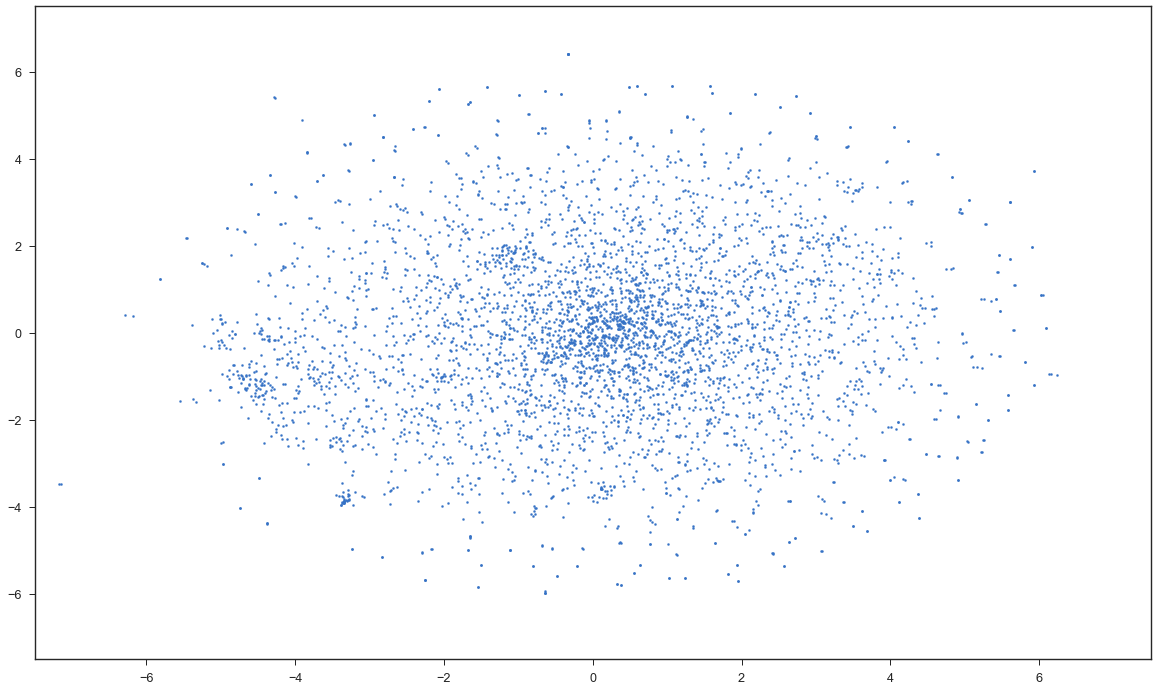

In [13]:
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

- **Some clustering but mostly just a big blob. Let's see if there's any relationship between genre and proximity.**

### Scatterplot -- all genres

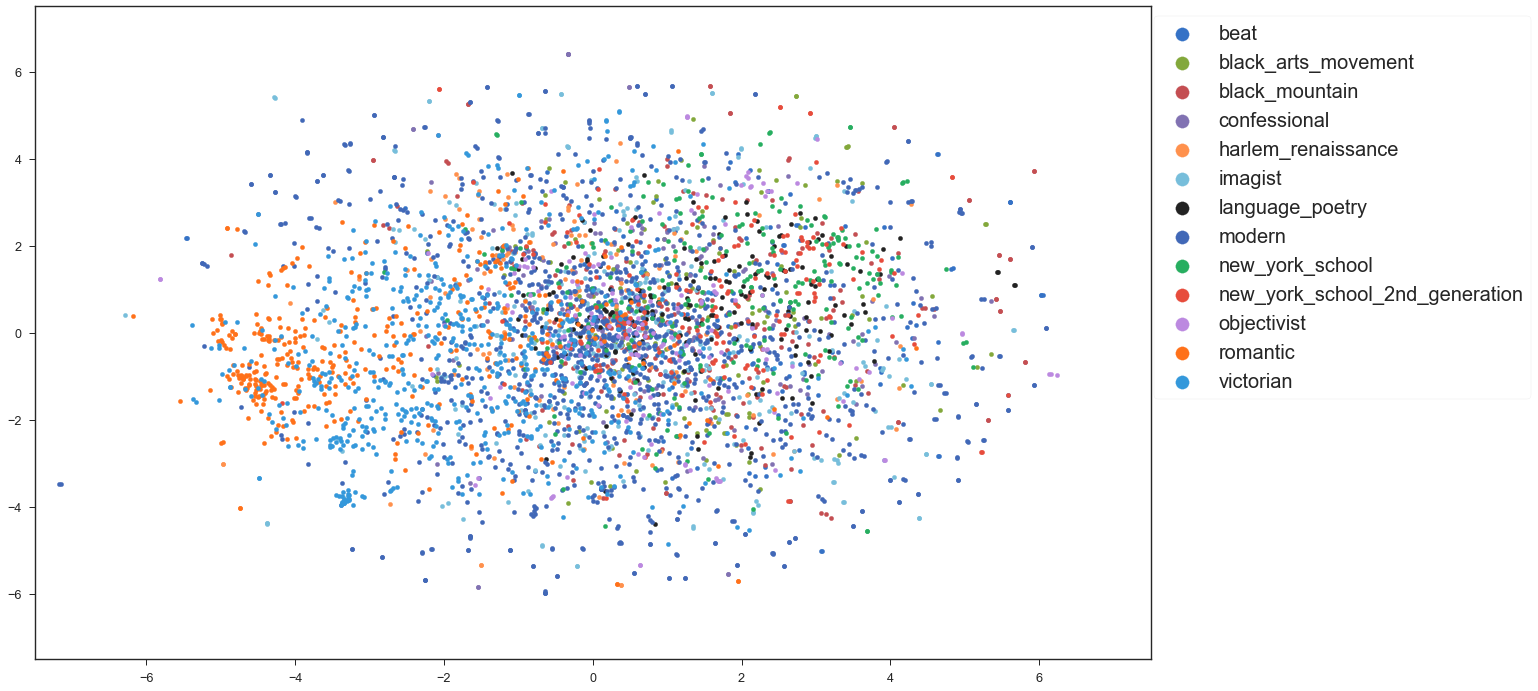

In [14]:
# create a list of all genres
genres = df['genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.35,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

##### Some clustering seems apparent but also a lot of noise. Also, it's difficult to differentiate due to similar colors. We might be able to clarify by looking at umbrella genres.
### Scatterplot -- umbrella genres

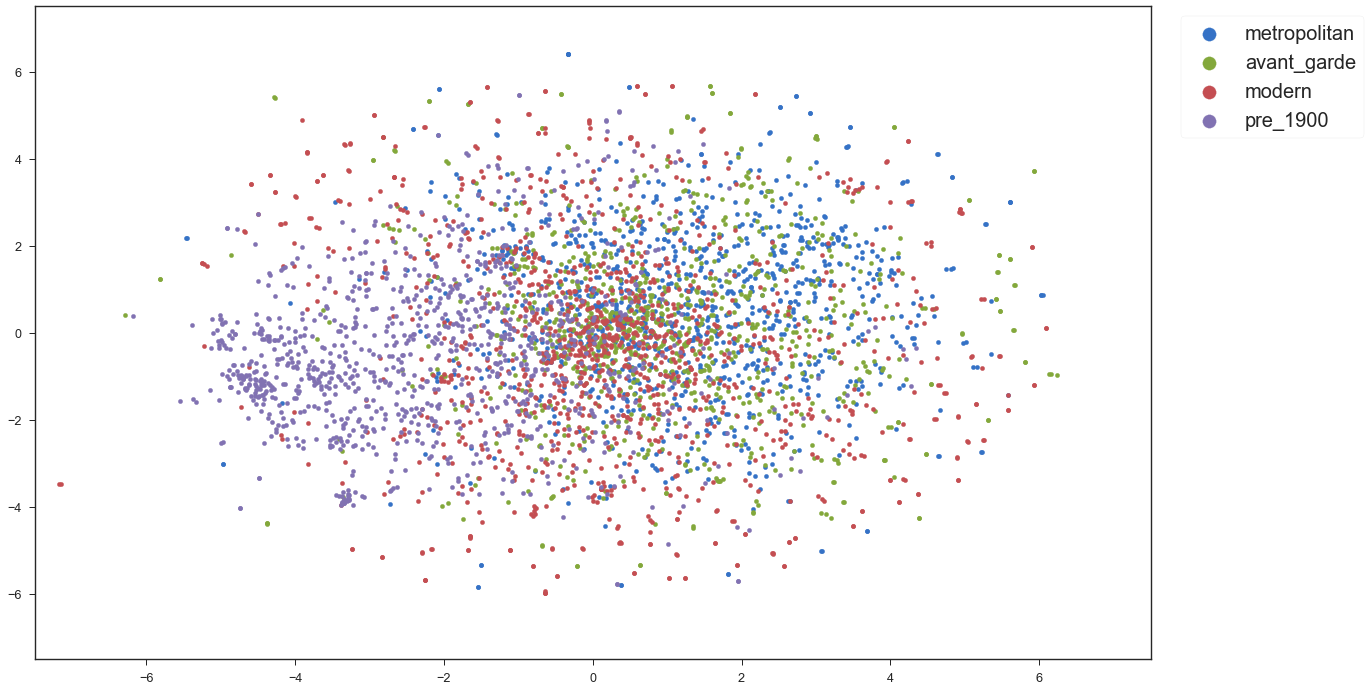

In [15]:
# create a list of all umbrella genres
genres = df['umbrella_genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'umbrella_genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.2,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
ax.set_xlim((-7.5,7.5))
ax.set_ylim((-7.5,7.5));

- **Some definite relationships here, but also a fair amount of overlap.**
- **This appears to confirm the separation of Pre-1900 poetry fairly nicely, though plenty of overlap remains.**
- **The other three umbrella genres seem fairly similar to each other.**
- **FUTURE CONSIDERATIONS:**
    - **LDA modeling to determine if that contributes to a Doc2Vec vector.**
    
## Test out some similarities

In [16]:
similar_poems = word_similarity('fire', df, model, num_poems=5, to_print=True)
similar_poems

34.1% match
POEM FOR TOM PICKARD by Tom Clark
GENRE: New York School 2Nd Generation
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30242/poem-for-tom-pickard
----------------------------------------------------------------------------------------------------
33.5% match
LIFE AT WAR by Denise Levertov
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30331/life-at-war
----------------------------------------------------------------------------------------------------
31.4% match
POMEGRANATE by D. H. Lawrence
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/148466/pomegranate-5bec49e88e4ca
----------------------------------------------------------------------------------------------------
30.3% match
BASEBALL AND CLASSICISM by Tom Clark
GENRE: New York School 2Nd Generation
URL: https://www.poetryfoundation.org/poems/47076/baseball-and-classicism
-------------------------------------------------------------------------------------------

[(3049, 0.3406328558921814),
 (508, 0.3353111147880554),
 (1877, 0.3137633502483368),
 (3023, 0.303056001663208),
 (733, 0.2990083694458008)]

In [17]:
similar_poems = text_similarity('Demand for Coronavirus Testing in U.S. Soars, Creating a New Crisis',
                                df, model, num_poems=5, to_print=True)
similar_poems

32.7% match
RECEPTION. THEORY. by P. Inman
GENRE: Language Poetry
URL: https://www.poetryfoundation.org/poems/54723/reception-theory
----------------------------------------------------------------------------------------------------
30.4% match
[BUT ISN’T MIDNIGHT INTERMITTENT] by Lyn Hejinian
GENRE: Language Poetry
URL: https://www.poetryfoundation.org/poems/56774/but-isnt-midnight-intermittent
----------------------------------------------------------------------------------------------------
25.6% match
WORK WITHOUT HOPE by Samuel Taylor Coleridge
GENRE: Romantic
URL: https://www.poetryfoundation.org/poems/43999/work-without-hope
----------------------------------------------------------------------------------------------------
24.5% match
PIECE by Rae Armantrout
GENRE: Language Poetry
URL: https://www.poetryfoundation.org/poetrymagazine/poems/144606/piece
----------------------------------------------------------------------------------------------------
24.0% match
AUTOBIOGRAPHY

[(1396, 0.3269566595554352),
 (1346, 0.3042953610420227),
 (3479, 0.2562117576599121),
 (1305, 0.24461811780929565),
 (1421, 0.2396545559167862)]

In [18]:
similar_poems = poem_similarity('Blizzard', df, model, num_poems=5, to_print=True)
similar_poems

44.7% match
GROWN ABOUT BY FRAGRANT BUSHES by Robert Louis Stevenson
GENRE: Victorian
URL: https://www.poetryfoundation.org/poems/45946/grown-about-by-fragrant-bushes
----------------------------------------------------------------------------------------------------
43.3% match
Q & A by Kenneth Fearing
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/52620/q-a
----------------------------------------------------------------------------------------------------
43.3% match
PERSPICUITY by Robert M. McAlmon
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/14337/perspicuity
----------------------------------------------------------------------------------------------------
42.6% match
THE CAMELLIA TREE OF MATSUE by Amy Lowell
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/13624/the-camellia-tree-of-matsue
----------------------------------------------------------------------------------------------------
41.7% match
YOU, ANDREW MA

[(4228, 0.4473862051963806),
 (1710, 0.43331336975097656),
 (2042, 0.43283936381340027),
 (998, 0.42648279666900635),
 (1957, 0.4174426794052124)]

## Visualize the model using T-SNE
- **The following code borrows heavily from Aaron Abrahamson's work: https://github.com/aabrahamson3/beer30**

In [9]:
# doc_tags is a list of every unique poem tag
doc_tags = [tag[1][0] for tag in model_corpus]

# get the vector for each doc_tag
X = model[doc_tags]

# fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=3,
            perplexity=50,
            learning_rate=10,
            n_iter=5000,
            n_jobs=-1, random_state=42)

X_tsne = tsne.fit_transform(X)

# convert to dataframe for easy graphing
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y', 'z'])

### Scatterplot -- all points

In [11]:
from mpl_toolkits.mplot3d import Axes3D

In [14]:
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
Axes3D.scatter(self=None, df_tsne['x'], df_tsne['y'], df_tsne['z'], s=5)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

SyntaxError: positional argument follows keyword argument (<ipython-input-14-10c12334e1ff>, line 3)

- **Some clustering but mostly just a big blob. Let's see if there's any relationship between genre and proximity.**

### Scatterplot -- all genres

In [ ]:
# create a list of all genres
genres = df['genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], genre_subset['z'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.35,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

##### Some clustering seems apparent but also a lot of noise. Also, it's difficult to differentiate due to similar colors. We might be able to clarify by looking at umbrella genres.
### Scatterplot -- umbrella genres

In [ ]:
# create a list of all umbrella genres
genres = df['umbrella_genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'umbrella_genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], genre_subset['z'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.2,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
ax.set_xlim((-7.5,7.5))
ax.set_ylim((-7.5,7.5));